# TensorRT Inference with TensorRT API
![process diagram](./doc/torchvision-trtapi.svg)

## IMPORTANT!
**Before you start this notebook, please shutdown other notebook kernels to allocate enough memory for this notebook.**   
<img src="./doc/kernel_shutdown.jpg" width="480">

## Prepare model and input image

Define a function to download a file.

In [1]:
import urllib
import os

def download_file(url, file=None):
    if file is None:
        file = os.path.basename(url)
    if os.path.exists(file):
        return file
    try:
        urllib.URLopener().retrieve(url, file)
    except:
        urllib.request.urlretrieve(url, file)
    return file

Specify a input image file.

In [2]:
image_file = 'bellpepper.jpg'
#image_file = download_file('https://github.com/pytorch/hub/raw/master/dog.jpg')
#image_file = download_file('https://upload.wikimedia.org/wikipedia/commons/b/b5/Canadian_Golden_Retriever.jpeg')

Download the ImageNet class file.

In [3]:
class_file = download_file('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')

Parse the class file and convert it to a Python dictionary.

In [4]:
import json
class_dict = json.load(open(class_file, 'r'))

Export the input image file to PyTorch tensor and normlize it in the ImageNet training image conditions.

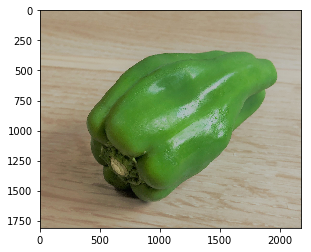

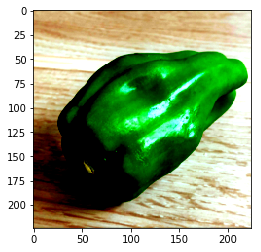

In [5]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

input_image = Image.open(image_file)
plt.imshow(input_image)
plt.show()

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

filtered_image = input_tensor.clone()
filtered_image = filtered_image.numpy().transpose((1, 2, 0))
filtered_image = np.float32(filtered_image)
filtered_image = np.clip(filtered_image, 0, 1)
plt.imshow(filtered_image)
plt.show()

Download the Torchvision AlexNet pre-traind model.

In [6]:
from torchvision import models
net = models.alexnet(pretrained=True)
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Build a TensorRT network with the TensorRT API

Extract the weight data and the bias data from the AlexNet pre-trained model.

In [7]:
weights = net.state_dict()
list(weights)

['features.0.weight',
 'features.0.bias',
 'features.3.weight',
 'features.3.bias',
 'features.6.weight',
 'features.6.bias',
 'features.8.weight',
 'features.8.bias',
 'features.10.weight',
 'features.10.bias',
 'classifier.1.weight',
 'classifier.1.bias',
 'classifier.4.weight',
 'classifier.4.bias',
 'classifier.6.weight',
 'classifier.6.bias']

Define a function to build a TensorRT network for the AlexNet model.

In [8]:
def define_trt_network(network, weights):
    # Input
    input_tensor = network.add_input(name='input', dtype=trt.float32, shape=(1, 3, 224, 224))
    
    # (features)
    
    # (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    layer = network.add_convolution( \
        input=input_tensor, num_output_maps=64, kernel_shape=(11, 11), \
        kernel=weights['features.0.weight'].numpy(), \
        bias=weights['features.0.bias'].numpy())
    layer.stride = (4, 4)
    layer.padding = (2, 2)
    
    # (1): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    layer = network.add_pooling( \
        input=layer.get_output(0), type=trt.PoolingType.MAX, window_size=(3, 3))
    layer.stride = (2, 2)
    
    # (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    layer = network.add_convolution( \
        input=layer.get_output(0), num_output_maps=192, kernel_shape=(5, 5), \
        kernel=weights['features.3.weight'].numpy(), \
        bias=weights['features.3.bias'].numpy())
    layer.stride = (1, 1)
    layer.padding = (2, 2)
    
    # (4): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    layer = network.add_pooling( \
        input=layer.get_output(0), type=trt.PoolingType.MAX, window_size=(3, 3))
    layer.stride = (2, 2)
    
    # (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    layer = network.add_convolution( \
        input=layer.get_output(0), num_output_maps=384, kernel_shape=(3, 3), \
        kernel=weights['features.6.weight'].numpy(), \
        bias=weights['features.6.bias'].numpy())
    layer.stride = (1, 1)
    layer.padding = (1, 1)
    
    # (7): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    layer = network.add_convolution( \
        input=layer.get_output(0), num_output_maps=256, kernel_shape=(3, 3), \
        kernel=weights['features.8.weight'].numpy(), \
        bias=weights['features.8.bias'].numpy())
    layer.stride = (1, 1)
    layer.padding = (1, 1)
    
    # (9): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    layer = network.add_convolution( \
        input=layer.get_output(0), num_output_maps=256, kernel_shape=(3, 3), \
        kernel=weights['features.10.weight'].numpy(), \
        bias=weights['features.10.bias'].numpy())
    layer.stride = (1, 1)
    layer.padding = (1, 1)
    
    # (11): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    layer = network.add_pooling( \
        input=layer.get_output(0), type=trt.PoolingType.MAX, window_size=(3, 3))
    layer.stride = (2, 2)
    
    # (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    layer = network.add_pooling( \
        input=layer.get_output(0), type=trt.PoolingType.AVERAGE, window_size=(1, 1))
    layer.stride = (1, 1)
    
    # (classifier)
    
    # (0): Dropout(p=0.5, inplace=False)
    
    # (1): Linear(in_features=9216, out_features=4096, bias=True)
    layer = network.add_shuffle(input=layer.get_output(0))
    layer.reshape_dims = (1, 9216)
    w = weights['classifier.1.weight'].numpy().T
    const_layer = network.add_constant(w.shape, w.reshape((-1,)))
    layer = network.add_matrix_multiply( \
        input0=layer.get_output(0), op0=trt.MatrixOperation.NONE, \
        input1=const_layer.get_output(0), op1=trt.MatrixOperation.NONE)
    b = weights['classifier.1.bias'].numpy().reshape(1, -1)
    const_layer = network.add_constant(b.shape, b.reshape((-1,)))
    layer = network.add_elementwise( \
        input1=layer.get_output(0),
        input2=const_layer.get_output(0),
        op=trt.ElementWiseOperation.SUM)
    
    # (2): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (3): Dropout(p=0.5, inplace=False)
    
    # (4): Linear(in_features=4096, out_features=4096, bias=True)
    layer = network.add_shuffle(input=layer.get_output(0))
    layer.reshape_dims = (1, 4096)
    w = weights['classifier.4.weight'].numpy().T
    const_layer = network.add_constant(w.shape, w.reshape((-1,)))
    layer = network.add_matrix_multiply( \
        input0=layer.get_output(0), op0=trt.MatrixOperation.NONE, \
        input1=const_layer.get_output(0), op1=trt.MatrixOperation.NONE)
    b = weights['classifier.4.bias'].numpy().reshape(1, -1)
    const_layer = network.add_constant(b.shape, b.reshape((-1,)))
    layer = network.add_elementwise( \
        input1=layer.get_output(0),
        input2=const_layer.get_output(0),
        op=trt.ElementWiseOperation.SUM)
    
    # (5): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (6): Linear(in_features=4096, out_features=1000, bias=True)
    layer = network.add_shuffle(input=layer.get_output(0))
    layer.reshape_dims = (1, 4096)
    w = weights['classifier.6.weight'].numpy().T
    const_layer = network.add_constant(w.shape, w.reshape((-1,)))
    layer = network.add_matrix_multiply( \
        input0=layer.get_output(0), op0=trt.MatrixOperation.NONE, \
        input1=const_layer.get_output(0), op1=trt.MatrixOperation.NONE)
    b = weights['classifier.6.bias'].numpy().reshape(1, -1)
    const_layer = network.add_constant(b.shape, b.reshape((-1,)))
    layer = network.add_elementwise( \
        input1=layer.get_output(0),
        input2=const_layer.get_output(0),
        op=trt.ElementWiseOperation.SUM)
    
    # Output
    layer.get_output(0).name = 'output'
    network.mark_output(tensor=layer.get_output(0))

Prepare the explicit batch flag for TensorRT.

In [9]:
import tensorrt as trt

EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

Define a function to generate a TensorRT engine.

In [10]:
import trt_analyzer

def build_engine_from_weights(weights, logger):
    with trt.Builder(logger) as builder, builder.create_network(EXPLICIT_BATCH) as network, builder.create_builder_config() as config, trt.Runtime(TRT_LOGGER) as runtime:
        config.max_workspace_size = 1 << 29
        # Define the TRT network using weights from the PyTorch model.
        define_trt_network(network, weights)
        # Get network info
        global net_dict
        net_dict = trt_analyzer.network_dict(network)
        # Build an engine.
        plan = builder.build_serialized_network(network, config)
        engine = runtime.deserialize_cuda_engine(plan)
        return engine

Build a TensorRT engine and do inference with it.

In [11]:
import common

net_dict = None
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)
engine_file_path = 'model_trtapi.trt'

with build_engine_from_weights(weights, TRT_LOGGER) as engine:
    inputs, outputs, bindings, stream = common.allocate_buffers(engine)
    with engine.create_execution_context() as context:
        inputs[0].host = input_batch.numpy()
        trt_outputs = common.do_inference_v2( \
            context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
        idxlist = np.argsort(trt_outputs[0])[:-4:-1]
        for i in idxlist:
            print('{}:\t{}'.format(class_dict[str(i)][1], trt_outputs[0][i]))
        with open(engine_file_path, "wb") as f:
            f.write(engine.serialize())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Use add_convolution_nd instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Use stride_nd instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Use padding_nd instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Use add_pooling_nd instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Use stride_nd instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Use add_convolution_nd instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Use stride_nd instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: Use padding_nd instead.
/usr/local/

bell_pepper:	15.886329650878906
cucumber:	13.747044563293457
Granny_Smith:	12.040936470031738


Print the TensorRT network.

In [12]:
import pandas as pd

pd.set_option('max_colwidth', 1000)
pd.DataFrame(net_dict)

,Name,Type,Inputs,Outputs,Type Specific Params
0,(Unnamed Layer* 0) [Convolution],LayerType.CONVOLUTION,"(1, 3, 224, 224)","(1, 64, 55, 55)","ksz=(11, 11) maps=64 stride=(4, 4) pad=(0, 0)"
1,(Unnamed Layer* 1) [Activation],LayerType.ACTIVATION,"(1, 64, 55, 55)","(1, 64, 55, 55)",type=ActivationType.RELU
2,(Unnamed Layer* 2) [Pooling],LayerType.POOLING,"(1, 64, 55, 55)","(1, 64, 27, 27)","type=PoolingType.MAX wsize=(3, 3) stride=(2, 2) pad=(0, 0)"
3,(Unnamed Layer* 3) [Convolution],LayerType.CONVOLUTION,"(1, 64, 27, 27)","(1, 192, 27, 27)","ksz=(5, 5) maps=192 stride=(1, 1) pad=(0, 0)"
4,(Unnamed Layer* 4) [Activation],LayerType.ACTIVATION,"(1, 192, 27, 27)","(1, 192, 27, 27)",type=ActivationType.RELU
5,(Unnamed Layer* 5) [Pooling],LayerType.POOLING,"(1, 192, 27, 27)","(1, 192, 13, 13)","type=PoolingType.MAX wsize=(3, 3) stride=(2, 2) pad=(0, 0)"
6,(Unnamed Layer* 6) [Convolution],LayerType.CONVOLUTION,"(1, 192, 13, 13)","(1, 384, 13, 13)","ksz=(3, 3) maps=384 stride=(1, 1) pad=(0, 0)"
7,(Unnamed Layer* 7) [Activation],LayerType.ACTIVATION,"(1, 384, 13, 13)","(1, 384, 13, 13)",type=ActivationType.RELU
8,(Unnamed Layer* 8) [Convolution],LayerType.CONVOLUTION,"(1, 384, 13, 13)","(1, 256, 13, 13)","ksz=(3, 3) maps=256 stride=(1, 1) pad=(0, 0)"
9,(Unnamed Layer* 9) [Activation],LayerType.ACTIVATION,"(1, 256, 13, 13)","(1, 256, 13, 13)",type=ActivationType.RELU


Define a function to recreate a TensorRT engine from a serialized TensorRT engine.

In [13]:
def build_engine_from_serialized(engine_file_path, logger):
    with open(engine_file_path, "rb") as f, trt.Runtime(logger) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

Recreate a TensorRT engine and do inference with it.

In [14]:
with build_engine_from_serialized(engine_file_path, TRT_LOGGER) as engine:
    inputs, outputs, bindings, stream = common.allocate_buffers(engine)
    with engine.create_execution_context() as context:
        inputs[0].host = input_batch.numpy()
        trt_outputs = common.do_inference_v2( \
            context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
        idxlist = np.argsort(trt_outputs[0])[:-4:-1]
        for i in idxlist:
            print('{}:\t{}'.format(class_dict[str(i)][1], trt_outputs[0][i]))

bell_pepper:	15.886329650878906
cucumber:	13.747044563293457
Granny_Smith:	12.040936470031738


## Work with custom layer

Import the pooling custom layer handling modules

In [15]:
import sys

cur_path = %pwd
plugin_path = os.path.join(cur_path, 'plugin')
sys.path.append(plugin_path)
from trt_plugin_pb2 import copy_Message
from trt_plugin_pb2 import pooling_Message
import trt_plugin_pb2

Load the pooling custom layer plugin.

In [16]:
import ctypes

lib_file = os.path.join(plugin_path, 'build', 'libPoolingPlugin.so')
lib = ctypes.CDLL(lib_file)

Get the plugin registry.

In [17]:
import tensorrt as trt

registry = trt.get_plugin_registry()
print([c.name for c in registry.plugin_creator_list])
print([c.plugin_namespace for c in registry.plugin_creator_list])

['CustomSkipLayerNormPluginDynamic', 'CustomSkipLayerNormPluginDynamic', 'CustomEmbLayerNormPluginDynamic', 'RnRes2Br1Br2c_TRT', 'RnRes2Br1Br2c_TRT', 'CustomQKVToContextPluginDynamic', 'CustomQKVToContextPluginDynamic', 'CustomSkipLayerNormPluginDynamic', 'CustomSkipLayerNormPluginDynamic', 'CustomGeluPluginDynamic', 'CustomEmbLayerNormPluginDynamic', 'CustomEmbLayerNormPluginDynamic', 'CgPersistentLSTMPlugin_TRT', 'SingleStepLSTMPlugin', 'RnRes2Br2bBr2c_TRT', 'RnRes2Br2bBr2c_TRT', 'CustomFCPluginDynamic', 'CustomQKVToContextPluginDynamic', 'GroupNormalizationPlugin', 'RnRes2FullFusion_TRT', 'InstanceNormalization_TRT', 'pooling', 'copy']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'macnica_trt_plugins', 'macnica_trt_plugins']


Register the plugin creator.

In [18]:
namespace = 'macnica_trt_plugins'
macnica_creators = [c for c in registry.plugin_creator_list if c.plugin_namespace == namespace]
for c in macnica_creators:
    registry.register_creator(c, namespace)

Define a function to build a TensorRT network for the AlexNet model with the pooling custom layer.

In [19]:
def define_trt_network(network, weights):
    # Input
    input_tensor = network.add_input(name='input', dtype=trt.float32, shape=(1, 3, 224, 224))
    
    # (features)
    
    # (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    layer = network.add_convolution( \
        input=input_tensor, num_output_maps=64, kernel_shape=(11, 11), \
        kernel=weights['features.0.weight'].numpy(), \
        bias=weights['features.0.bias'].numpy())
    layer.stride = (4, 4)
    layer.padding = (2, 2)
    
    # (1): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    '''
    layer = network.add_pooling( \
        input=layer.get_output(0), type=trt.PoolingType.MAX, window_size=(3, 3))
    layer.stride = (2, 2)
    '''
    ### Custom Pooling Layer with CUDA or cuDNN ###
    creator = registry.get_plugin_creator( \
        type='pooling', version='1', plugin_namespace='macnica_trt_plugins')
    sz = layer.get_output(0).shape
    message = pooling_Message( \
        dims=sz, mode=trt_plugin_pb2.Maximum, window=[3, 3], stride=[2,2], \
        impl=trt_plugin_pb2.CUDA)
    plg = creator.deserialize_plugin('pooling', message.SerializeToString())
    layer = network.add_plugin_v2(inputs=[layer.get_output(0)], plugin=plg)
    
    # (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    layer = network.add_convolution( \
        input=layer.get_output(0), num_output_maps=192, kernel_shape=(5, 5), \
        kernel=weights['features.3.weight'].numpy(), \
        bias=weights['features.3.bias'].numpy())
    layer.stride = (1, 1)
    layer.padding = (2, 2)
    
    # (4): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    '''
    layer = network.add_pooling( \
        input=layer.get_output(0), type=trt.PoolingType.MAX, window_size=(3, 3))
    layer.stride = (2, 2)
    '''
    ### Custom Pooling Layer with CUDA or cuDNN ###
    sz = layer.get_output(0).shape
    message = pooling_Message( \
        dims=sz, mode=trt_plugin_pb2.Maximum, window=[3, 3], stride=[2,2], \
        impl=trt_plugin_pb2.CUDA)
    plg = creator.deserialize_plugin('pooling', message.SerializeToString())
    layer = network.add_plugin_v2(inputs=[layer.get_output(0)], plugin=plg)
    
    # (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    layer = network.add_convolution( \
        input=layer.get_output(0), num_output_maps=384, kernel_shape=(3, 3), \
        kernel=weights['features.6.weight'].numpy(), \
        bias=weights['features.6.bias'].numpy())
    layer.stride = (1, 1)
    layer.padding = (1, 1)
    
    # (7): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    layer = network.add_convolution( \
        input=layer.get_output(0), num_output_maps=256, kernel_shape=(3, 3), \
        kernel=weights['features.8.weight'].numpy(), \
        bias=weights['features.8.bias'].numpy())
    layer.stride = (1, 1)
    layer.padding = (1, 1)
    
    # (9): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    layer = network.add_convolution( \
        input=layer.get_output(0), num_output_maps=256, kernel_shape=(3, 3), \
        kernel=weights['features.10.weight'].numpy(), \
        bias=weights['features.10.bias'].numpy())
    layer.stride = (1, 1)
    layer.padding = (1, 1)
    
    # (11): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    '''
    layer = network.add_pooling( \
        input=layer.get_output(0), type=trt.PoolingType.MAX, window_size=(3, 3))
    layer.stride = (2, 2)
    '''
    ### Custom Pooling Layer with CUDA or cuDNN ###
    sz = layer.get_output(0).shape
    message = pooling_Message( \
        dims=sz, mode=trt_plugin_pb2.Maximum, window=[3, 3], stride=[2,2], \
        impl=trt_plugin_pb2.CUDA)
    plg = creator.deserialize_plugin('pooling', message.SerializeToString())
    layer = network.add_plugin_v2(inputs=[layer.get_output(0)], plugin=plg)
    
    # (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    layer = network.add_pooling( \
        input=layer.get_output(0), type=trt.PoolingType.AVERAGE, window_size=(1, 1))
    layer.stride = (1, 1)
    
    # (classifier)
    
    # (0): Dropout(p=0.5, inplace=False)
    
    # (1): Linear(in_features=9216, out_features=4096, bias=True)
    layer = network.add_shuffle(input=layer.get_output(0))
    layer.reshape_dims = (1, 9216)
    w = weights['classifier.1.weight'].numpy().T
    const_layer = network.add_constant(w.shape, w.reshape((-1,)))
    layer = network.add_matrix_multiply( \
        input0=layer.get_output(0), op0=trt.MatrixOperation.NONE, \
        input1=const_layer.get_output(0), op1=trt.MatrixOperation.NONE)
    b = weights['classifier.1.bias'].numpy().reshape(1, -1)
    const_layer = network.add_constant(b.shape, b.reshape((-1,)))
    layer = network.add_elementwise( \
        input1=layer.get_output(0),
        input2=const_layer.get_output(0),
        op=trt.ElementWiseOperation.SUM)
    
    # (2): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (3): Dropout(p=0.5, inplace=False)
    
    # (4): Linear(in_features=4096, out_features=4096, bias=True)
    layer = network.add_shuffle(input=layer.get_output(0))
    layer.reshape_dims = (1, 4096)
    w = weights['classifier.4.weight'].numpy().T
    const_layer = network.add_constant(w.shape, w.reshape((-1,)))
    layer = network.add_matrix_multiply( \
        input0=layer.get_output(0), op0=trt.MatrixOperation.NONE, \
        input1=const_layer.get_output(0), op1=trt.MatrixOperation.NONE)
    b = weights['classifier.4.bias'].numpy().reshape(1, -1)
    const_layer = network.add_constant(b.shape, b.reshape((-1,)))
    layer = network.add_elementwise( \
        input1=layer.get_output(0),
        input2=const_layer.get_output(0),
        op=trt.ElementWiseOperation.SUM)
    
    # (5): ReLU(inplace=True)
    layer = network.add_activation( \
        input=layer.get_output(0), type=trt.ActivationType.RELU)
    
    # (6): Linear(in_features=4096, out_features=1000, bias=True)
    layer = network.add_shuffle(input=layer.get_output(0))
    layer.reshape_dims = (1, 4096)
    w = weights['classifier.6.weight'].numpy().T
    const_layer = network.add_constant(w.shape, w.reshape((-1,)))
    layer = network.add_matrix_multiply( \
        input0=layer.get_output(0), op0=trt.MatrixOperation.NONE, \
        input1=const_layer.get_output(0), op1=trt.MatrixOperation.NONE)
    b = weights['classifier.6.bias'].numpy().reshape(1, -1)
    const_layer = network.add_constant(b.shape, b.reshape((-1,)))
    layer = network.add_elementwise( \
        input1=layer.get_output(0),
        input2=const_layer.get_output(0),
        op=trt.ElementWiseOperation.SUM)
    
    # Output
    layer.get_output(0).name = 'output'
    network.mark_output(tensor=layer.get_output(0))

Build a TensorRT network with the custom layer and do inference with the network.

In [20]:
net_dict = None

with build_engine_from_weights(weights, TRT_LOGGER) as engine:
    inputs, outputs, bindings, stream = common.allocate_buffers(engine)
    with engine.create_execution_context() as context:
        inputs[0].host = input_batch.numpy()
        trt_outputs = common.do_inference_v2( \
            context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
        idxlist = np.argsort(trt_outputs[0])[:-4:-1]
        for i in idxlist:
            print('{}:\t{}'.format(class_dict[str(i)][1], trt_outputs[0][i]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Use add_convolution_nd instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Use stride_nd instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Use padding_nd instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Use add_convolution_nd instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Use stride_nd instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Use padding_nd instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: Use add_convolution_nd instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: Use stride_nd instead.
/usr/lo

bell_pepper:	15.886329650878906
cucumber:	13.747044563293457
Granny_Smith:	12.040936470031738


Print the TensorRT network.

In [21]:
pd.DataFrame(net_dict)

,Name,Type,Inputs,Outputs,Type Specific Params
0,(Unnamed Layer* 0) [Convolution],LayerType.CONVOLUTION,"(1, 3, 224, 224)","(1, 64, 55, 55)","ksz=(11, 11) maps=64 stride=(4, 4) pad=(0, 0)"
1,(Unnamed Layer* 1) [Activation],LayerType.ACTIVATION,"(1, 64, 55, 55)","(1, 64, 55, 55)",type=ActivationType.RELU
2,(Unnamed Layer* 2) [PluginV2Ext],LayerType.PLUGIN_V2,"(1, 64, 55, 55)","(1, 64, 27, 27)",
3,(Unnamed Layer* 3) [Convolution],LayerType.CONVOLUTION,"(1, 64, 27, 27)","(1, 192, 27, 27)","ksz=(5, 5) maps=192 stride=(1, 1) pad=(0, 0)"
4,(Unnamed Layer* 4) [Activation],LayerType.ACTIVATION,"(1, 192, 27, 27)","(1, 192, 27, 27)",type=ActivationType.RELU
5,(Unnamed Layer* 5) [PluginV2Ext],LayerType.PLUGIN_V2,"(1, 192, 27, 27)","(1, 192, 13, 13)",
6,(Unnamed Layer* 6) [Convolution],LayerType.CONVOLUTION,"(1, 192, 13, 13)","(1, 384, 13, 13)","ksz=(3, 3) maps=384 stride=(1, 1) pad=(0, 0)"
7,(Unnamed Layer* 7) [Activation],LayerType.ACTIVATION,"(1, 384, 13, 13)","(1, 384, 13, 13)",type=ActivationType.RELU
8,(Unnamed Layer* 8) [Convolution],LayerType.CONVOLUTION,"(1, 384, 13, 13)","(1, 256, 13, 13)","ksz=(3, 3) maps=256 stride=(1, 1) pad=(0, 0)"
9,(Unnamed Layer* 9) [Activation],LayerType.ACTIVATION,"(1, 256, 13, 13)","(1, 256, 13, 13)",type=ActivationType.RELU
